In [39]:
import os
import tensorflow as tf
from tensorflow.keras import layers, callbacks, optimizers
import matplotlib.pyplot as plt
import numpy as np

In [40]:
train_dir = 'vwwd_train'
val_dir = 'vwwd_val'

print("Number of samples:")
print("Train: ")
for f in os.listdir(train_dir + '/'):
    if os.path.isdir(train_dir + '/' + f):
        print(f, " : ", len(os.listdir(train_dir + '/' + f +'/')))

print("Validation: ")
for f in os.listdir(val_dir + '/'):
    if os.path.isdir(val_dir + '/' + f):
        print(f, " : ", len(os.listdir(val_dir + '/' + f +'/')))

Number of samples:
Train: 
both  :  2000
left  :  1757
no  :  2000
right  :  1779
Validation: 
both  :  1000
left  :  852
no  :  1000
right  :  856


In [46]:
batch_size = 32

print("Training set")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  image_size=(64, 64),
  validation_split=0.2,
  subset="training",
  seed=123,
  batch_size=batch_size)

print("Validation set")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  image_size=(64, 64),
  validation_split=0.2,
  subset="validation",
  seed=123,
  batch_size=batch_size)

Training set
Found 7536 files belonging to 4 classes.
Using 6029 files for training.
Validation set
Found 3708 files belonging to 4 classes.
Using 741 files for validation.


In [47]:
class_names = train_ds.class_names
print(len(class_names))

for image_batch, labels_batch in train_ds:
    input_shape = image_batch[0].shape
    print("Input: ", image_batch.shape)
    print("Labels: ", labels_batch.shape)
    break

4


Input:  (32, 64, 64, 3)
Labels:  (32,)


In [48]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [49]:
# MobileNetV1_0.25
base_model = tf.keras.applications.MobileNet(input_shape=input_shape, weights='imagenet', alpha=0.25, include_top=False)

base_model.trainable = False

inputs = tf.keras.Input(shape=input_shape)

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(class_names), activation = 'softmax')(x)    # Add own classififcation layer

model = tf.keras.Model(inputs, outputs)

cb = [callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)]
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 mobilenet_0.25_224 (Functio  (None, 2, 2, 256)        218544    
 nal)                                                            
                                                                 
 global_average_pooling2d_3   (None, 256)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 219,572
Trainable params: 1,028
Non-trainable params: 218,544
_________________________________________________________________


In [50]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(0.01), metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[cb])

Epoch 1/100
189/189 [==============================] - 17s 61ms/step - loss: 1.6626 - accuracy: 0.3402 - val_loss: 1.6139 - val_accuracy: 0.3711
Epoch 2/100
189/189 [==============================] - 10s 50ms/step - loss: 1.5707 - accuracy: 0.3533 - val_loss: 1.6028 - val_accuracy: 0.3914
Epoch 3/100
189/189 [==============================] - 10s 49ms/step - loss: 1.5636 - accuracy: 0.3652 - val_loss: 1.6556 - val_accuracy: 0.3428
Epoch 4/100
189/189 [==============================] - 12s 59ms/step - loss: 1.4845 - accuracy: 0.3714 - val_loss: 1.5637 - val_accuracy: 0.3590
Epoch 5/100
189/189 [==============================] - 11s 58ms/step - loss: 1.5092 - accuracy: 0.3697 - val_loss: 1.5285 - val_accuracy: 0.3455
Epoch 6/100
189/189 [==============================] - 12s 60ms/step - loss: 1.5062 - accuracy: 0.3749 - val_loss: 1.5032 - val_accuracy: 0.3846
Epoch 7/100
189/189 [==============================] - 15s 77ms/step - loss: 1.5116 - accuracy: 0.3734 - val_loss: 1.4760 - val_ac

In [51]:
model.evaluate(val_ds)

24/24 [==============================] - 1s 28ms/step - loss: 1.4760 - accuracy: 0.3765


[1.4760363101959229, 0.37651821970939636]

In [52]:
def plot(history, variable, variable2):
    plt.plot(range(len(history[variable])), history[variable])
    plt.plot(range(len(history[variable2])), history[variable2])
    plt.title(variable)

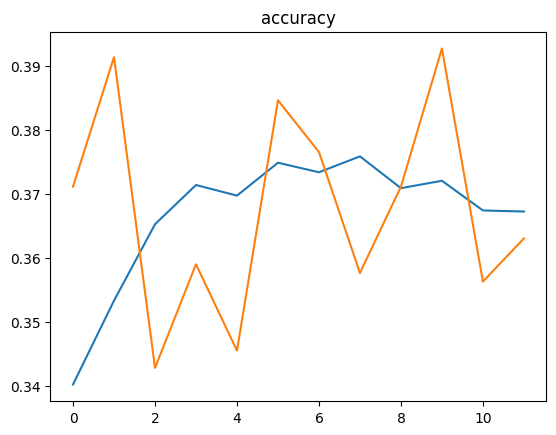

In [53]:
plot(history.history, "accuracy", 'val_accuracy')

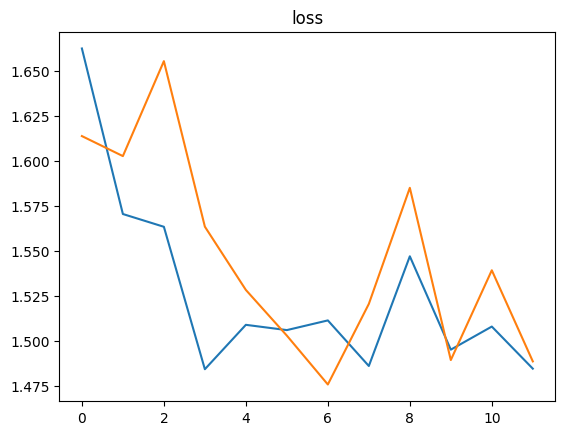

In [54]:
plot(history.history, "loss", "val_loss")

In [55]:
# Save model as normal
model.save('model.h5')

In [56]:
# Save model as tflite
# Prequantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('pre_quantized.tflite', 'wb') as f:
    f.write(tflite_model)

# Quantize model (full integer quantization)
def representative_dataset_gen():
    for input_value, _ in train_ds:
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

# Save quantized model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model_quant)


INFO:tensorflow:Assets written to: C:\Users\ADMIN\AppData\Local\Temp\tmp5znw6iog\assets


INFO:tensorflow:Assets written to: C:\Users\ADMIN\AppData\Local\Temp\tmp5znw6iog\assets


INFO:tensorflow:Assets written to: C:\Users\ADMIN\AppData\Local\Temp\tmp3nkkqe64\assets


INFO:tensorflow:Assets written to: C:\Users\ADMIN\AppData\Local\Temp\tmp3nkkqe64\assets
d:\ESP32_Thingy\.conda\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
from tensorflow.lite.python.util import convert_bytes_to_c_source
a, b = convert_bytes_to_c_source(tflite_model_quant, 'tflite')
with open("model.h", "w") as f:
    f.write(b)
with open("model.cc", "w") as f:
    f.write(a)